## Random Forest Base

### Data Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-12-12 10:58:03.571836: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-12-12 10:58:03.571857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Reading Data
dir_name="../../data/member_001"

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2=read_xarray(dir_name)

mld=mld.isel(bnds=0)
sss=sss.isel(bnds=0)
sst=sst.isel(bnds=0)
xco2=xco2.isel(bnds=0)


mld['time'] =mld.time.indexes['time'].to_datetimeindex()
sss['time'] =sss.time.indexes['time'].to_datetimeindex()
sst['time'] =sst.time.indexes['time'].to_datetimeindex()
xco2['time'] =xco2.time.indexes['time'].to_datetimeindex()

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_1015911/3409989473.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mld['time'] =mld.time.indexes['time'].to_datetimeindex()
/tmp/ipykernel_1015911/3409989473.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sss['time'] =sss.time.indexes['time'].to_datetimeinde

In [3]:

pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")
xco2['time'] =xco2.time.dt.strftime("%Y-%m")

In [4]:
# Creating one singular df
data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])

In [5]:
tmp_data=data_read.to_dataframe().reset_index()
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

In [6]:
# tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
# tmp_data["Chl"]=chl_data["Chl"]
# tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
# tmp_data["pCO2"]=pco2_data["pCO2"]

In [7]:
check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()

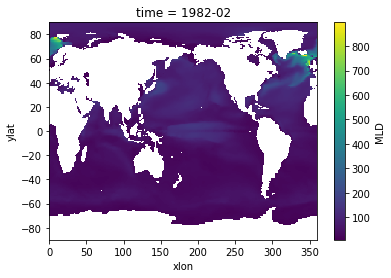

In [9]:
check.MLD[1].plot()

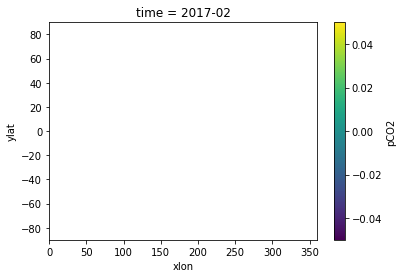

In [10]:
check.pCO2[421].plot()

In [8]:
tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

In [48]:
features_socat = ['time','xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

In [49]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [50]:
combined.head()

,time,xlon,ylat,SST,SSS,Chl,XCO2,pCO2
64820,1982-02,0.5,-69.5,-1.552322,33.641834,0.064728,340.848541,259.943180
64821,1982-02,0.5,-68.5,-1.626047,33.667816,0.079743,340.848541,264.257161
64822,1982-02,0.5,-67.5,-1.607591,33.572289,0.077933,340.848541,269.302537
64823,1982-02,0.5,-66.5,-1.496069,33.424641,0.069886,340.848541,275.715089
64824,1982-02,0.5,-65.5,-1.207762,33.317802,0.060309,340.848541,285.947764


In [12]:
combined_socat.isna().sum()

time          0
xlon          0
ylat          0
MLD_socat     0
SST_socat     0
SSS_socat     0
Chl_socat     0
XCO2          0
pCO2_socat    0
dtype: int64

In [51]:
#separating X and y
X_socat=combined_socat.iloc[:,1:-1]
X=combined.iloc[:,1:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


In [14]:
combined.xlon.min(),combined.xlon.max(),combined.ylat.min(),combined.ylat.max()

(0.5, 359.5, -77.5, 89.5)

In [53]:
# Two Different Imputation Methods

# KNNImputer
# from sklearn.impute import KNNImputer
# imp = KNNImputer(n_neighbors=2)
# X=imp.fit_transform(X)
# X_socat=imp.fit_transform(X_socat)

# SimpleImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

### Modeling - Random Forest: full




In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s finished


RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, random_state=42,
                      verbose=3, warm_start=True)

In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Scores: [20.38981969 20.37132857 20.43572299]
Mean: 20.398957081643985
Standard deviation: 0.027071253594377603


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


### Final Result: full

Socat RMSE: 

Whole Grid Rmse: 

In [57]:
# On Socat
y_pred=regressor.predict(X_socat)
test_mse=mean_squared_error(y_socat, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


20.153309276060092

In [58]:
## The whole grid
y_pred=regressor.predict(X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s finished


In [59]:
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

31.367750555451675

### Modeling - Random Forest Full


Uses train_test_split build into sklearn.model_selection


By default this method shuffles the data (30% = testing 70%=training/validation)
- Will test validation via 7-fold cross validation

Train  = 70%, Test   = 30%

In [47]:

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)


In [49]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

regressor=RandomForestRegressor(n_estimators=20, random_state=42)
regressor.fit(X_train, y_train)

forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=7)
forest_rmse_scores = np.sqrt(-forest_scores)

In [50]:
display_scores(forest_rmse_scores)

Scores: [29.73571217 29.5882607  29.78134202 29.4693389  29.85141169 29.5449631
 29.88748243]
Mean: 29.694073002857216
Standard deviation: 0.14901955512485043


In [51]:
#Fine Tuning Using RandomizedSearch

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=20, high=50),
        'max_features': randint(low=1, high=6),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=7, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

final_model =rnd_search.best_estimator_



building tree 1 of 20
building tree 5 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 1 of 20
building tree 6 of 20
building tree 13 of 20
building tree 14 of 20
building tree 20 of 20
building tree 4 of 20
building tree 6 of 20
building tree 11 of 20
building tree 12 of 20
building tree 18 of 20
building tree 4 of 20
building tree 8 of 20
building tree 12 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 15 of 20
building tree 16 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 15 of 20
building tree 16 of 20
building tree 19 of 20
building tree 2 of 20
building tree 6 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 11 of 20
building tree 12 of 20
building tree 19 of 20
building tree 3 of 20
building tree 8 of 20
building tree 13 of 20
building tree 14 of 20
buildin

In [52]:
final_model =rnd_search.best_estimator_


### Final Result

Test Set RMSE: 23.818525580843453

Whole Grid Rmse: 40.38668015093895

In [25]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


31.05017990803373

In [26]:
## The whole grid
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.4s finished


In [27]:
final_test_rmse

35.965692698148494

### Visualization of the Residual

In [60]:
combined["residual"] = error

In [61]:
combined["pred"] = y_pred

In [62]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()


In [63]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()

In [64]:
ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

(array([5.000000e+00, 5.940000e+02, 2.073000e+03, 1.994000e+03,
        2.524000e+03, 6.593000e+03, 2.404800e+04, 1.197610e+05,
        6.968990e+05, 4.060454e+06, 8.084238e+06, 2.930866e+06,
        7.023880e+05, 2.643520e+05, 1.563960e+05, 1.018340e+05,
        4.423400e+04, 1.960500e+04, 9.679000e+03, 6.127000e+03,
        4.401000e+03, 3.399000e+03, 2.455000e+03, 1.795000e+03,
        1.221000e+03, 7.380000e+02, 4.380000e+02, 2.150000e+02,
        6.700000e+01, 7.000000e+00]),
 array([-260.63595114, -235.53294398, -210.42993682, -185.32692967,
        -160.22392251, -135.12091535, -110.0179082 ,  -84.91490104,
         -59.81189388,  -34.70888673,   -9.60587957,   15.49712759,
          40.60013474,   65.7031419 ,   90.80614906,  115.90915621,
         141.01216337,  166.11517053,  191.21817768,  216.32118484,
         241.424192  ,  266.52719915,  291.63020631,  316.73321347,
         341.83622062,  366.93922778,  392.04223494,  417.14524209,
         442.24824925,  467.3512564 , 

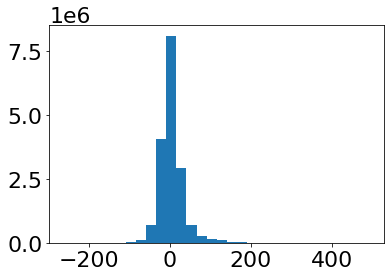

In [65]:
plt.hist(error,bins=30)

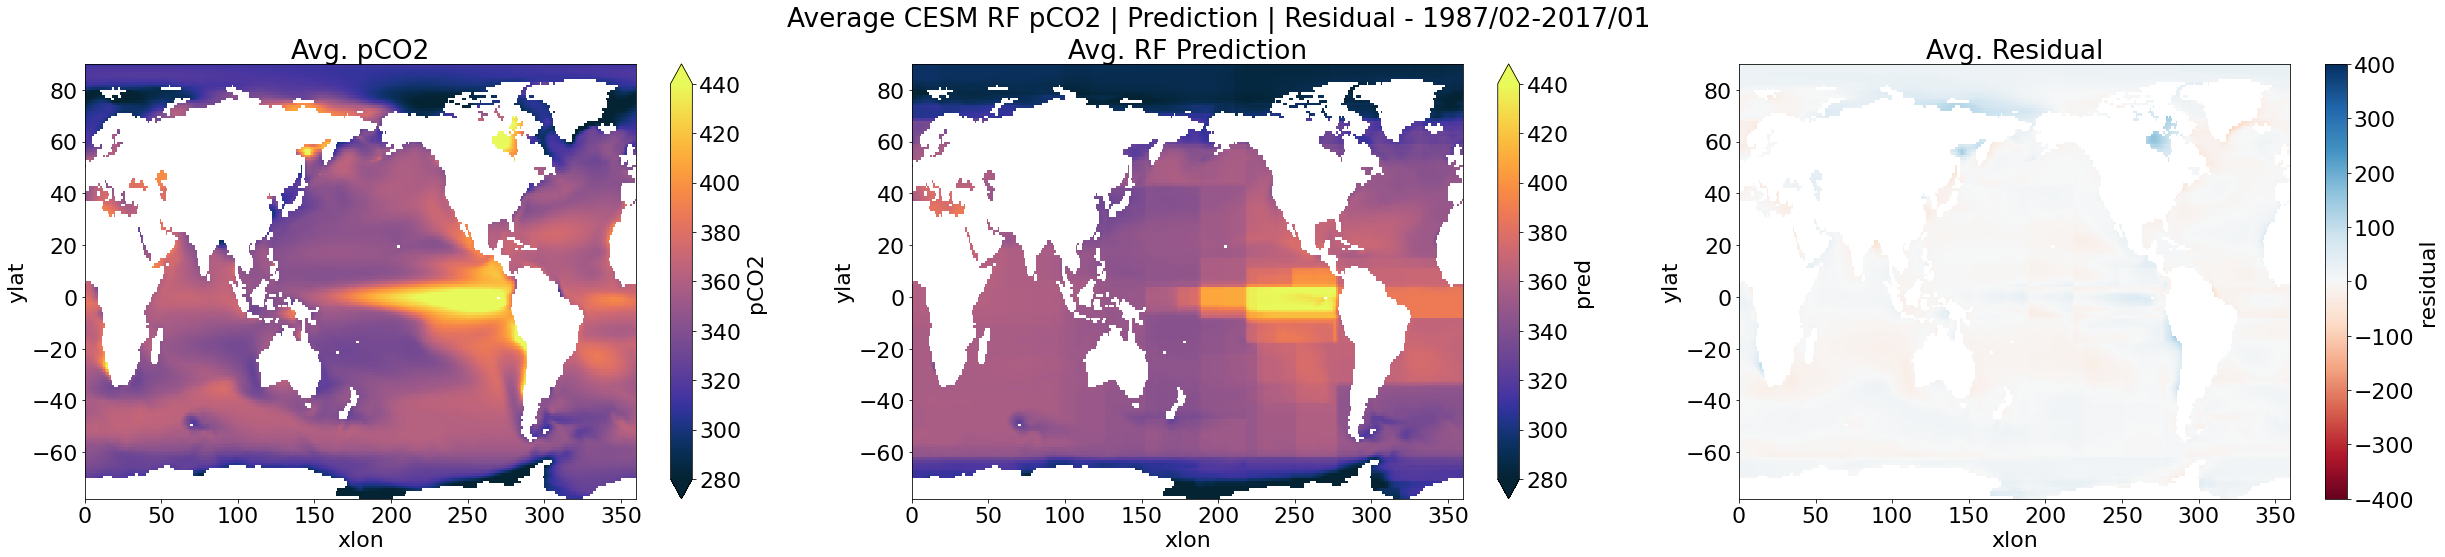

In [66]:
plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

ds_pred.pCO2.mean('time').plot(ax = axis[0],cmap = cm.cm.thermal,norm=norm)
axis[0].set_title("Avg. pCO2")

ds_pred.pred.mean('time').plot(ax = axis[1],cmap = cm.cm.thermal,norm=norm)
axis[1].set_title("Avg. RF Prediction")


norm2 = mcolors.TwoSlopeNorm(vmin=-400, vmax = 400, vcenter=0)

ds.residual.mean('time').plot(ax = axis[2],cmap = "RdBu",norm=norm2)
axis[2].set_title("Avg. Residual")

figure.suptitle("Average CESM RF pCO2 | Prediction | Residual - 1987/02-2017/01")

plt.savefig("../../assets/figure2.2_rf_socat.jpg")

In [67]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.13.5


In [68]:
combined_tmp.reset_index(inplace=True)
avg_time=combined_tmp.groupby(by="time").mean()
avg_time_res = avg_time["residual"]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


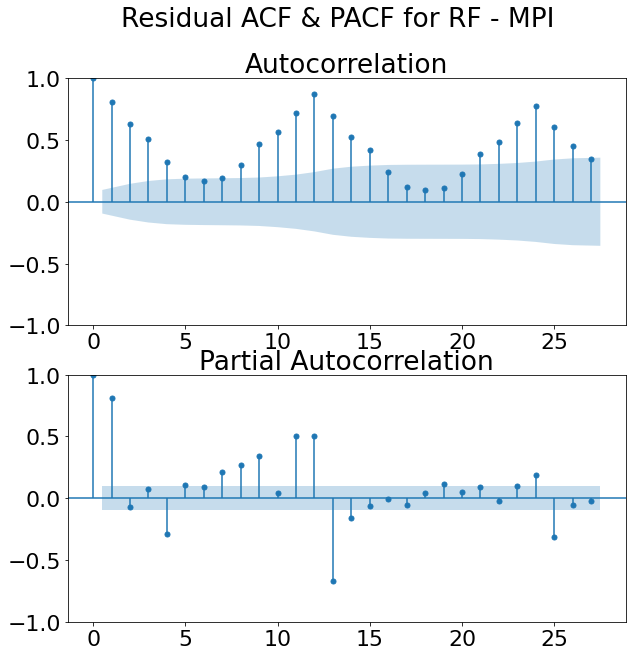

building tree 3 of 20
building tree 5 of 20
building tree 10 of 20
building tree 14 of 20
building tree 17 of 20
building tree 1 of 20
building tree 6 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 5 of 20
building tree 9 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 13 of 20
building tree 14 of 20
building tree 19 of 20
building tree 3 of 20
building tree 5 of 20
building tree 9 of 20
building tree 10 of 20
building tree 17 of 20
building tree 3 of 20
building tree 6 of 20
building tree 9 of 20
building tree 10 of 20
building tree 17 of 20
building tree 1 of 20
building tree 5 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 11 of 20
building tree 15 of 20
building tree 19 of 20
building tree 3 of 20
building tree 5 of 20
building tree 9 of 20
building tree 13 of 20
building t

In [69]:
fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for RF - MPI")

plt.savefig("../../assets/figur6.1_rf_cesm_acf_socat.jpg")
pyplot.show()